In [1]:
# import libraries
from __future__ import division
import pandas as pd
import numpy as np
import re
import os
import sys

import matplotlib.mlab as mlab
import matplotlib.pyplot as plt
%matplotlib inline  

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, accuracy_score

In [2]:
# some hard-coded threshold to data clean-up and standarization

rxName_rxNDC_repeating = 10 # num of co-occurances of rxName - rxNDC pair to be considered as valid
num_of_drugs_displayed = 3 # num of most common medications for each disease displayed for Q1

# Index
    * Import data and data cleanup
        * meds dataset cleanup
        * base_data standardization
    * Q1 common used medication by disease
    * Q2 indicative medication for each disease
    * Q3 logisticregression modeling of highBP disease
        * training data preparation
        * building model
    * Q4 model performance discussion
    * Q5 statistical test of gender preference of a specific drug usage for highBP patients
    

# 1 import data and data cleanup 

In [3]:
data_path = os.path.join(os.getcwd(), 'data')

In [4]:
# import the data, discard the first column (index), and drop duplicate records
base_data = pd.read_csv(os.path.join(data_path, 'meps_base_data.csv'))
base_data = base_data.drop(base_data.columns[0], axis = 1).drop_duplicates()
meds = pd.read_csv(os.path.join(data_path, 'meps_meds.csv'))
meds = meds.drop(meds.columns[0], axis = 1).drop_duplicates()

## 1-1 meds dataset cleanup
meds dataset contains many malformed records, especially the rxName and rxNDC fields. Due to time limits, I mainly fix two issues. 
* 1, rxName with comments in parenthesis
* 2, for drug with same rxDNC, there are multiple written convention for rxName

In [5]:
# rxName with comments, some are in parenthesis, I deleted those characters in parenthesis, 
# I also deleted heading/trailing spaces

meds['rxName'] = meds['rxName'].str.replace(r"\(.*\)", "")
meds['rxName'] = meds['rxName'].str.replace(r"\(.*", "")
meds['rxName'] = meds['rxName'].str.replace(r"\)", "")
meds['rxName'] = meds['rxName'].str.strip()

In [6]:
# I noticed that there are cases where the rxNDC is the same, but rxName is different probably due to the fact that
# it's coming from multiple sources with different recording practice.
# clean-up solution: for rxName - rxNDC pair that appeared often (above rxName_rxNDC_repeating = 10), considered as valid pairs
# find the most commonly used rxName for that rxNDC, 
# and use the most commonly used rxName to replace other rxName with same rxNDC code

# find rxName - rxNDC pair that appeared more than threshold rxName_rxNDC_repeating = 10
valid_meds = meds.groupby(['rxName', 'rxNDC'])['id'].count()[meds.groupby(['rxName', 'rxNDC'])['id'].count() > rxName_rxNDC_repeating].reset_index()
valid_meds.rename(columns = {'id': 'count'}, inplace = True)
valid_meds = valid_meds[valid_meds['rxNDC'] > 0]

# find rxNDC with multiple rxName
repeating_ndc = valid_meds['rxNDC'].value_counts()[valid_meds['rxNDC'].value_counts() > 1].index.values

# for rxNDC with multiple rxName, find the most commonly used rxName
# replace other rxName with same rxNDC with the most commonly used one
# build a dict to store it for future usage
rxName_fix_dict = {}
for ndc in repeating_ndc:
    # find the index and the most frequent rxName for each rxNDC
    idx = valid_meds.loc[valid_meds['rxNDC'] == ndc, 'count'].idxmax()
    most_common_rxName = valid_meds.loc[idx, 'rxName']
    
    # save it in a dict for future reference
    for name in valid_meds.loc[valid_meds['rxNDC'] == ndc, 'rxName']:
        rxName_fix_dict[(ndc, name)] = most_common_rxName

In [7]:
def rxName_cleanup(rxName, rxNDC, rxName_fix_dict = rxName_fix_dict):
    '''
    function to fix the issue that multiple rxName exsiting for same rxNDC, based on the pre-built dict
    '''
    try:
        return rxName_fix_dict[(rxNDC, rxName)]
    
    except:
        return rxName

In [8]:
meds['rxName'] = meds.apply(lambda x: rxName_cleanup(x['rxName'], x['rxNDC'], rxName_fix_dict), axis = 1)

## 1-2 data standardization

In [9]:
columns_disease = base_data.columns[7:]

# for the diagnose of each disease, convert it into yes/not-yes boolean type
for column in columns_disease:
    base_data[column] = (base_data[column] == 'Yes').astype('int')

# 2 Question 1: what are the most common medications for each disease in the base file

There is a strong co-occurances of multiple diseases. It's hard to tell which medication is used for what disease.
So I only considered cases where patient is diagnosed with one disease and calculated the most common medications for those patients. There are much less data points when calculated this way, but I think it's more accurate. 

I also include the code to do calculation without this filter in the patient_with_only_one_disease function, it's commented out.

In [10]:
# considering the 'real' datasets will be very large, run computation before doing join

def patient_with_only_one_disease(disease, columns_disease = columns_disease, base_data = base_data):
    '''
    return the id for people diggnosed with only one disease and it's the targeted disease
    '''
    
    return base_data[(base_data[columns_disease].sum(axis = 1) == 1) & (base_data[disease] == 1)]['id'].values
    #return base_data[(base_data[disease] == 1)]['id'].values

In [11]:
def medication_lookup_for_patients(ids, cnt = None, meds = meds):
    '''
    find the mostly commonly used drug for patients in ids list
    Only count the drug once for each patient
    '''
    
    meds = meds[['id', 'rxName']].drop_duplicates()
    if cnt is None:
        return meds[meds['id'].isin(ids)]['rxName'].value_counts() # return all the drugs being used
    else:
        return meds[meds['id'].isin(ids)]['rxName'].value_counts()[:cnt] # return the most commonly used drugs

In [12]:
# loop through all diseases and export top num_of_drugs_displayed = 3 drugs used
q1_summary = pd.DataFrame()
for disease in columns_disease:    
    ids = patient_with_only_one_disease(disease)
    most_common_medication = medication_lookup_for_patients(ids, cnt = num_of_drugs_displayed)/len(ids)
    combine = [index + ' (' + str(round(value, 2)) + ')' for index, value in most_common_medication.iteritems()]
    
    q1_summary[disease + ' (' + str(len(ids)) + ' patients)'] = combine

In [13]:
q1_summary

,highBPDiagnosed (6676 patients),diabetesDiagnosed (833 patients),chdDiagnosed (80 patients),miDiagnosed (41 patients),anginaDiagnosed (42 patients),strokeDiagnosed (164 patients),emphysemaDiagnosed (100 patients),asthmaDiagnosed (3942 patients),otherHDDiagnosed (817 patients),heartFailureDiagnosed (19 patients)
0,LISINOPRIL (0.17),METFORMIN (0.45),SIMVASTATIN (0.16),HYDROCO/APAP (0.22),AZITHROMYCIN (0.19),SIMVASTATIN (0.15),HYDROCO/APAP (0.18),ALBUTEROL (0.22),AZITHROMYCIN (0.15),FUROSEMIDE (0.16)
1,HYDROCHLOROTHIAZIDE (0.12),LISINOPRIL (0.17),HYDROCO/APAP (0.11),SIMVASTATIN (0.15),AMOXICILLIN (0.1),AZITHROMYCIN (0.13),SPIRIVA (0.18),AMOXICILLIN (0.16),AMOXICILLIN (0.14),TRAMADOL HCL (0.11)
2,SIMVASTATIN (0.11),SIMVASTATIN (0.16),METOPROLOL TARTRATE (0.1),AZITHROMYCIN (0.12),HYDROCO/APAP (0.1),AMOXICILLIN (0.1),AZITHROMYCIN (0.12),AZITHROMYCIN (0.14),HYDROCO/APAP (0.11),AMLODIPINE (0.11)


## 2 - 1 Q1 summary:
### Please see above for the most commonly used medication for each disease

# 3 Question 2: what medications are most indicative of each disease?

The proxy value is to calculate probability of disease given the medication. I used conditional probability to do it

Conditional probabiliity: 
P(disease | medication) = P(medication | disease) * P(disease) / P(medication)

I create three dictionarys to store the probability for future usage. It's probably easier/cleaner to do the calculation inplace without it. The three probabilities on the right of equation is estimated from different subset of the data, which results in P(disease | medication) to be an estimation. It does not fall into range of 0 to 1. But the value represents the relative likelyhood.

In [14]:
# Using the same method as question 1 to calculate p(medication | disease)
medication_given_disease = {}

for disease in columns_disease:    

    ids = patient_with_only_one_disease(disease)
    medication_given_disease[disease] = (medication_lookup_for_patients(ids)/len(ids)).to_dict()

In [15]:
def prob_medication_giving_disease(medication, disease, medication_given_disease = medication_given_disease):
    '''
    calculate P(medication | disease), following same method as question 1
    '''
    try:
        return medication_given_disease[disease][medication]
    
    except:
        return 0 #return 0 if the medication is not used by anyone in the current dataset

In [16]:
# calculate the probability of each disease P(disease) with base_data
prob_disease = {}

for disease in columns_disease:
    prob_disease[disease] = len(base_data[base_data[disease] == 1])/len(base_data)

In [17]:
def find_prob_disease(disease, prob_disease = prob_disease):
    '''
    Calculate P(disease)
    '''
    try:
        return prob_disease[disease]
    except:
        print ('not such disease in database')
        raise

In [18]:
# calculate the probability of each medication being used P(medication)
tmp1 = meds[['id', 'rxName']].drop_duplicates() # only count the usage of each medication once
num_ids = len(tmp1['id'].drop_duplicates())

prob_medication = (tmp1['rxName'].value_counts()/num_ids).to_dict()

In [19]:
def find_prob_meds(meds, prob_medication = prob_medication):
    '''
    calculate P(medication)
    '''
    try:
        return prob_medication[meds]
    except:
        print ('not such medication in database')
        raise

In [20]:
# get the all the commonly used medication for each disease
common_medications = set()
for disease in columns_disease:
    ids = patient_with_only_one_disease(disease)
    common_medications |= set(medication_lookup_for_patients(ids, 20).index.values )

common_medications = list(common_medications)

In [21]:
def cal_prob_disease_given_medication(disease, medications = common_medications):
    '''
    calculate the P(disease | medication) using the previously describe conditional probability
    '''
        
    probs = [prob_medication_giving_disease(medication, disease) * find_prob_disease(disease) / find_prob_meds(medication)
            for medication in medications]
    
    # probs = [prob/max(probs) for prob in probs] # to normalized the probability
        
    result = pd.DataFrame(data = {'medications':medications, 'probability': probs})
    result.sort_values(by = 'probability', axis = 0, ascending = False, inplace = True)
    return result

In [22]:
q2_summary = pd.DataFrame()

for disease in columns_disease:
    tmp2 = cal_prob_disease_given_medication(disease, common_medications)
    tmp3 = tmp2.apply(lambda row: row['medications'] + ' (' + str(round(row['probability'], 3)) + ')', axis = 1)
    q2_summary[disease] = tmp3.values

In [23]:
# note that the probability is relative (not in range of 0 - 1)
q2_summary.head(5)

,highBPDiagnosed,diabetesDiagnosed,chdDiagnosed,miDiagnosed,anginaDiagnosed,strokeDiagnosed,emphysemaDiagnosed,asthmaDiagnosed,otherHDDiagnosed,heartFailureDiagnosed
0,LISINOP/HCTZ (0.668),ACTOS (0.68),PHENYTOIN SODIUM EXTENDED (0.319),PANTOPRAZOLE (0.237),AMERGE (1.841),PHENYTOIN SODIUM EXTENDED (0.52),CEROVITE SILVER (1.233),PULMICORT RESPULES (0.56),AMERGE (0.322),CEROVITE SENIOR (15.486)
1,HYDROCHLOROTHIAZIDE (0.56),ONETOUCH (0.64),ZETIA (0.198),NITROGLYCERIN (0.196),PRISTIQ (0.449),PRISTIQ (0.314),SPIRIVA (0.339),FLOVENT HFA (0.539),MORPHINE SULFATE (0.195),CERTAGEN (3.871)
2,HYDROCHLOROT (0.531),METFORMIN (0.591),FLOMAX (0.172),METOPROLOL SUCCINATE (0.185),PREMARIN (0.1),CHANTIX (0.1),CHANTIX (0.16),ADVAIR DISKUS 100/50 (0.497),WARFARIN SODIUM (0.164),CEROVITE SILVER (3.097)
3,AMLODIPINE (0.506),METFORMIN HCL (0.571),TOPROL XL (0.151),PROVENTIL HFA (0.185),CHANTIX (0.095),RANITIDINE (0.057),COMBIVENT (0.14),PROVENTIL (0.475),CHANTIX (0.15),TUSSIN DM (1.106)
4,DIOVAN (0.505),GLYBURIDE (0.563),METOPROLOL SUCCINATE (0.145),METOPROLOL SUCCINATE ER (0.183),DIAZEPAM (0.092),GABAPENTIN (0.055),FLOVENT HFA (0.108),ALBUTEROL (0.462),DIAZEPAM (0.12),OYSCO 500 (0.704)


## 3 - 1 Q2 summary:
### Please see above for the most indicative medication for each disease

# 4 Question 3, choose one of the diseases and build a model to infer whether that disease is present from the medications

For the purpose of easy interpretation, I choose a linear model to predict presence of disease.
Due to time limitations, I didn't consider other models. If time permits, I would set up an evaluation dataset to do a model selection or use ensembel methods. Also time can be spent on tunning hyperparamters to improve the model performance.

I choose 'highBPDiagnosed' as the target disease to do the demo. The dataset is pretty imbalanced with 20% of people in the dataset are diagnosed with highBP. Accuracy is not the best metrics to evaluate the model performance. AUC is used instead. Also the threshold of decision p=0.5 is tuned due to fact that in reality people may have weights over precision or recall rate, especially it's a disease prediction model.

## 4 - 1 training data preparation

In [24]:
target_disease = 'highBPDiagnosed'

In [25]:
meds_training = meds.copy()

In [26]:
# There are thousands of medications in the dataset. 
# To build a simpler model, I categorized the medication used by no more than 10 persons as uncommon_drug. 
# Also there are many invalid drugs (or with redundant information), I labeled drug start with '-' (often as negative num)
# as unknown_drug. If time permits, more data cleanup can be done.

meds_person_unique = meds_training[['id', 'rxName']].drop_duplicates()

valid_rxName = meds_person_unique['rxName'].value_counts()[meds_person_unique['rxName'].value_counts() > 10].index.values
meds_training.loc[~meds_training['rxName'].isin(valid_rxName), 'rxName'] = 'uncommon_drug'

meds_training['rxName'] = meds_training['rxName'].apply(lambda x: 'unknown_drug' if x[0] == '-' else x)

In [27]:
# pivot the meds_training table
meds_training_pivot = pd.crosstab(index = meds_training['id'], columns = meds_training['rxName'], values = meds_training['rxQuantity'], aggfunc = sum)

meds_training_pivot.reset_index(inplace = True)

In [28]:
# join the base_data with the meds_training_pivot data
all_data = base_data[['id', 'panel', 'pooledWeight', 'age', 'sex', 'race', 'married', target_disease]].merge(
                meds_training_pivot, how = 'left', left_on = 'id', right_on = 'id')

all_data.drop(['id'], axis = 1, inplace = True)

In [29]:
# outlier cleanup for age, fill people with age = -1 with the mean value

mean_age = round(all_data[all_data['age'] >=0]['age'].mean(), 0)
all_data['age'] = all_data['age'].apply(lambda x: mean_age if x < 0 else x )

In [30]:
# outlier cleanup for pooledweight, fill people with extreme pooledWeight with median value

median_pooledWeight = all_data['pooledWeight'].median()
q1_pooledWeight = all_data['pooledWeight'].quantile(0.25)
q3_pooledWeight = all_data['pooledWeight'].quantile(0.75)
all_data['pooledWeight'] = all_data['pooledWeight']\
            .apply(lambda x: median_pooledWeight if x > q3_pooledWeight + 1.5*(q3_pooledWeight - q1_pooledWeight) else x)

In [31]:
# fill nan value with 0
all_data = all_data.fillna(0)

In [32]:
X = pd.get_dummies(all_data).drop([target_disease], axis = 1)
Y = all_data[target_disease]

Xtrain, Xtest, Ytrain, Ytest = train_test_split(X, Y, test_size = 0.3)

## 4 - 2 Train a linear model

In [33]:
seed = 2018

In [34]:
Xtrain_only,Xvalid,Ytrain_only,Yvalid = train_test_split(Xtrain,Ytrain,test_size=0.2,random_state=seed)

In [35]:
# train on training set
lrcv_train_only = LogisticRegressionCV(scoring = 'roc_auc', penalty = 'l2', max_iter=1000, n_jobs = 1)
lrcv_train_only.fit(Xtrain_only, Ytrain_only)

# predict on validation set
yvalid_probas = lrcv_train_only.predict_proba(Xvalid)[:, 1]

In [36]:
roc = pd.DataFrame()
roc['FPR'],roc['TPR'],roc['Threshold'] = roc_curve(Yvalid,yvalid_probas)

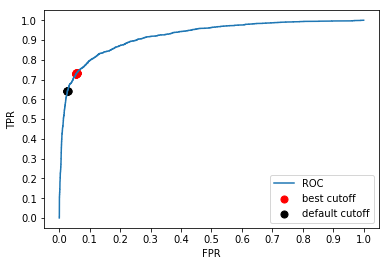

In [37]:
# plot ROC
plt.plot(roc.FPR,roc.TPR,label='ROC')
plt.xlabel("FPR")
plt.ylabel('TPR')

ticks = np.linspace(0,1,11)
plt.yticks(ticks)
plt.xticks(ticks)

# plot best thresholds
best_cutoffs = roc.loc[ (roc.Threshold > 0.30) & (roc.Threshold < 0.31),:]
default_cutoffs = roc.loc[ (roc.Threshold > 0.50) & (roc.Threshold < 0.51),:]
plt.scatter(best_cutoffs.FPR,best_cutoffs.TPR,c='r',s=50,label='best cutoff')
plt.scatter(default_cutoffs.FPR,default_cutoffs.TPR,c='k',s=50,label='default cutoff')


plt.rc('figure',figsize=(10,5))
plt.legend(loc='best')

In [38]:
# retrain with all the training data

In [39]:
lrcv = LogisticRegressionCV(scoring = 'roc_auc', penalty = 'l2', max_iter=1000, n_jobs = 1)
lrcv.fit(Xtrain, Ytrain)

LogisticRegressionCV(Cs=10, class_weight=None, cv=None, dual=False,
           fit_intercept=True, intercept_scaling=1.0, max_iter=1000,
           multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
           refit=True, scoring='roc_auc', solver='lbfgs', tol=0.0001,
           verbose=0)

# 5 Question 4, Demonstrate that the end user should be confident in the result

The performance of the trained logisticregression model is benchmarked with test data.

In [40]:
# pick the threshold 0.3 based on the discussion in previous section
proba_threshold = 0.3

In [41]:
ytest_pred_proba = lrcv.predict_proba(Xtest)[:, 1]
ytest_pred = (ytest_pred_proba > proba_threshold).astype(int)

In [42]:
print 'test accuracy: ', accuracy_score(Ytest, ytest_pred)

test accuracy:  0.897977991001


In [43]:
print classification_report(Ytest, ytest_pred)

             precision    recall  f1-score   support

          0       0.93      0.94      0.94     14360
          1       0.79      0.74      0.76      4087

avg / total       0.90      0.90      0.90     18447



## 5-  1 Q4 summary: 
* 1 The accuracy for the trained model is 0.89
* 2 The precision and recall rate is 0.79 and 0.74 for patients with highBP, respectively. Overall it has a pretty balanced prediction for highBP patients.

# 6 Question 5: can you find any evidence that for the disease you've modeled, a certain drug is preferred by a certain demographic subgroup?

To narrow down the question, I decided to look into one disease and one drug, to check whether there is a gender preferenece for simplest reason. 

disease: highBPDiagnosed  
medication: 'HYDROCHLOROTHIAZIDE'   # second indicative drug based on the results in Q2

p1: probability of using HYDROCHLOROTHIAZIDE for male patients diagnosed with highBP    
P2: probability of using HYDROCHLOROTHIAZIDE for female patients diagnosed with highBP

## Null hypothesis: p1 = p2
    * For patients diagnosed with highBP, there is no preference towards usage of medication HYDROCHLOROTHIAZIDE between female and male patients.
    
    
    
## Alternative hypothesis: p1 <> p2

significance level: 0.05

In [44]:
target_drug = 'HYDROCHLOROTHIAZIDE'

In [45]:
drug_preference_data = all_data[(all_data[target_disease] == 1)][['pooledWeight', 'age', 'sex', 'race', 'married', target_drug]]

In [46]:
drug_preference_data['target_drug_used'] = (drug_preference_data[target_drug] > 0).astype(int)

In [47]:
drug_preference_gender = pd.crosstab(index = drug_preference_data['sex'], columns= drug_preference_data['target_drug_used'])
drug_preference_gender

target_drug_used,0,1
sex,,
Female,6302,1065
Male,5574,696


## 6 - 1
### Chi square statistical test is performed for category - category variables.

In [48]:
from scipy.stats import chi2_contingency

def chisq_of_df_cols(df, c1, c2):
    groupsizes = df.groupby([c1, c2]).size()
    ctsum = groupsizes.unstack(c1)
    # fillna(0) is necessary to remove any NAs which will cause exceptions
    rchi2, p, dof, expected = (chi2_contingency(ctsum.fillna(0)))
    return p

p_value = chisq_of_df_cols(drug_preference_data, 'target_drug_used', 'sex')
print p_value

6.69101894442e-09


## 6 - 2
### Statistical test result: the p_value is much smaller than the significance level (0.05), we cannot accept the null hypothesis.

In [49]:
# if we model the choice of HYDROCHLOROTHIAZIDE usage for highBP patients as a binomial process
# we can calculate the usage_ratio and its standard deviation following a binomial distribution
drug_uage_ratio_female = 1065/(6302 + 1065)
drug_usage_ratio_male = 696/(5574 + 696)
drug_uage_ratio_female_std = np.sqrt(1065/(6302 + 1065)/(6302 + 1065))
drug_uage_ratio_female_std = np.sqrt(696/(5574 + 696)/(5574 + 696))

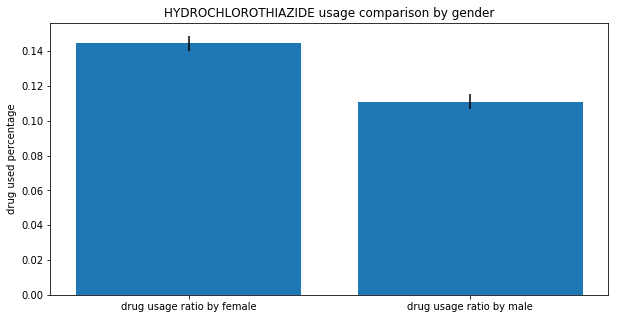

In [50]:
drug_used_ratio = (drug_uage_ratio_female, drug_usage_ratio_male)
drug_used_ratio_std = (drug_uage_ratio_female_std, drug_uage_ratio_female_std)
ind = (1, 2)    # the x locations for the groups

p1 = plt.bar(ind, drug_used_ratio, yerr=drug_used_ratio_std)

plt.ylabel('drug used percentage')
plt.title('%s usage comparison by gender' % target_drug)
plt.xticks(ind, ('drug usage ratio by female', 'drug usage ratio by male'))

plt.show()

## 6 - 3
### Q5 Conclusion: From the graph we can, there is a higher probability that female highBP patients would use HYDROCHLOROTHIAZIDE compared with male highBP patients